In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import simpleaudio as sa
from scipy import signal
import wavio

In [2]:
with open('dmrb.pickle', 'rb') as handle:
    dmrb = pickle.load(handle)
df = pd.DataFrame(dmrb,dtype=np.float64)
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df.astype(float,inplace=True)
colsDrop = ['05476500','05476590','05476735','05478265','05480080','05480820','05480930','05489490','05481510','05482315','05482430','05483318','05483349','05483470','05484600']
df.drop(columns = colsDrop ,inplace=True)

In [3]:
rootgages = {'05484900':'raccoon','05482000':'upper','05490500':'lower'}
# Gaged areas
upper = 6245
raccoon = 3625
total = 14038
lower = total - raccoon - upper

In [26]:
def waveform(t,d,extras=[]):
    # Form
    # [method,a,f]
    
    func = {'sin':np.sin, 'saw':signal.sawtooth, 'square':signal.square}
    
    # create base wave form with dominant freq and harmonic(s)
    wave = d[1] * func[d[0]](d[2] * t * 2 * np.pi) + d[1]/2 * func[d[0]](2 * d[2] * t * 2 * np.pi) 
    
    # and movement given other gages (upstream)
    # [method,a,f]
    for w in extras:
        wave += w[1] * func[w[0]](2 * np.pi * w[2] * t)
    
    return wave

def linkTones(tones):
    for t in tones:
        l = int(len(t)/4)
        for i in range(0,l):
            t[len(t) - l+i] *= (1 - i /l)
            t[i] *= i/l
            
    full = np.concatenate(tones)
    full = full * (2**15 - 1) / np.max(np.abs(full))
    return full.astype(np.int16)

def linearFlow2Freq(flow,flowLimits,freqLimits,relationship='negative'):
    lowFreq = 130
    highFreq = 1300
    
    lowFlow = 0
    highFlow = 90000
    
    if relationship == 'negative':
        freq = (freqLimits[0] - freqLimits[1])/(flowLimits[1] - flowLimits[0]) * flow + freqLimits[1]
    else:
        freq = (freqLimits[1] - freqLimits[0])/(flowLimits[1] - flowLimits[0]) * flow + freqLimits[0]
        
    return freq

In [68]:
# pentatonic C maj
freq = [130.81,146.83,164.81,196,220,261.63,293.66,329.63,392,440,523.25,587.3,659.26,783.99,880,1046]
freqinv = freq[::-1][6:]
# Something else
# freq = [261.63,277.18,293.66,311.13,329.63,349.23,369.99,392,415.3,440,466.16,493.88]

freq = [261.63,277.18,329.63,349.23,415.30,493.88,523.25


In [135]:
# Dominants
root = '05490500' # Lower
# root = '05482000' # Upper
# root = '05484900' # Raccoon

flowLims = (0,90000)
freqLims = (130,440)


root = '05488110'
data = df[root][365:750].astype(np.float64)
## ---- Either or ----
# bins = np.linspace(data.min(), data.max(), 9)
# digitized = np.digitize(data,bins)
bins = np.linspace(np.log(data.min()), np.log(data.max()), 9)
digitized = np.digitize(np.log(data),bins)
## -------------------
fd = [freqinv[i-1] for i in digitized]
# fd = [linearFlow2Freq(i,flowLims,freqLims) for i in data.values]
ad = np.abs((1 - (data.mean())/data.max() - data)/10)

root2 = '05487520'
data = df[root2][365:750].astype(np.float64)
## ---- Either or ----
# bins = np.linspace(data.min(), data.max(), 9)
# digitized = np.digitize(data,bins)
bins = np.linspace(np.log(data.min()), np.log(data.max()), 9)
digitized = np.digitize(np.log(data),bins)
## -------------------
fd2 = [freqinv[i-1] for i in digitized]
# fd = [linearFlow2Freq(i,flowLims,freqLims) for i in data.values]
ad2 = np.abs((1 - (data.mean())/data.max() - data)/10)

# Saw
sawGage = '05487470'
data = df[sawGage][365:750].astype(np.float64)
bins = np.linspace(np.log(data.min()), np.log(data.max()), 9)
digitized = np.digitize(np.log(data),bins)
# fsaw = [freq[i+8] for i in digitized]
fsaw = [freq[i+4] for i in digitized]
# fsaw = [linearFlow2Freq(i,(0,90000),(130,500)) for i in data.values]
asaw = (1 - (data - data.mean())/data.max())
asaw =[460/lower for i in asaw]

# Square 
squareGage = '05488200'
data = df[squareGage][365:750].astype(np.float64)
bins = np.linspace(np.log(data.min()), np.log(data.max()), 9)
digitized = np.digitize(np.log(data),bins)
# fsqr = [freq[i+8] for i in digitized]
fsqr = [freq[i+4] for i in digitized]
# fsqr = [linearFlow2Freq(i,(0,90000),(130,500)) for i in data.values]
asqr = (1 - (data - data.mean())/data.max())
asqr = [90/lower for i in asqr]

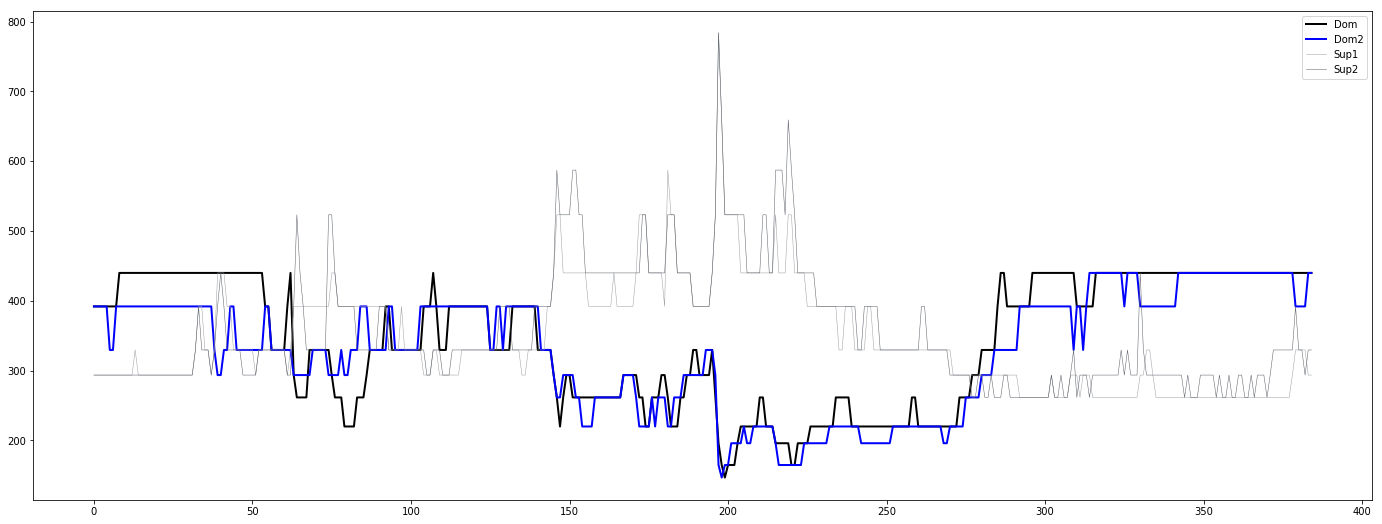

In [136]:
plt.figure(figsize=(24,9))
plt.plot(fd,color='k',linewidth=2)
plt.plot(fd2,color='b',linewidth=2)
plt.plot(fsaw,color='#9ea0a3',linewidth=0.5)
plt.plot(fsqr,color='#5b6068',linewidth=0.5)
plt.legend(['Dom','Dom2','Sup1','Sup2'])
plt.show()

In [137]:
totalPlayTime = 60 # sec
dayPlay = totalPlayTime / len(data) # length of note/day in seconds

fs = 44100 # samples per second
t = np.linspace(0, dayPlay, dayPlay * fs, False)

totalSamples = totalPlayTime * fs

In [138]:
tones = []
for a,f,a2,f2,asw,fsw,asq,fsq in zip(ad,fd,ad2,fd2,asaw,fsaw,asqr,fsqr): # unit days
    
    #dominant tone
    dom = ['sin',a,f]
           
    # give extras
    extra = []
    extra.append(['sin',a2,f2])
    extra.append(['saw',asw,fsw])
    extra.append(['square',asq,fsq])
    
    tone = waveform(t,dom,extra)
    
    tones.append(tone)

full = linkTones(tones)

In [139]:
# Wait for playback to finish before exiting
play_obj = sa.play_buffer(full, 1, 2, fs)
play_obj.wait_done()

In [134]:
fileName = "GeneralBrosAwesomeChicken.wav"
wavio.write(fileName, full, fs, sampwidth=2)

In [37]:
# for t in tones:
#     l = int(len(t)/4)
#     for i in range(0,l):
#         t[len(t) - l+i] *= (1 - i /l)
#         t[i] *= i/l

In [39]:
# full = np.concatenate(tones)
# full = full * (2**15 - 1) / np.max(np.abs(full))
# full = full.astype(np.int16)

In [37]:
# t = np.linspace(0, 2, 2 * fs, False)
# full = t * np.sin(2 * np.pi * 440 * t)
# print(len(full))
# full = full * (2**15 - 1) / np.max(np.abs(full))
# full = full.astype(np.int16)

88200


In [38]:
# play_obj = sa.play_buffer(full, 1, 2, 44100)

In [7]:
# def flow2freqBinMap(data,freq,bins=[False,0],log=[False,True]):
#     if log[0]:
#         data = np.log(data)
#     else:
#         pass
    
#     # numb bins
#     if bins[0]:
#         numBins = bins[0]
#     else:
#         numBins = len(freq)
        
#     if log[1]:
#         MIN = np.log(data.min())
#         MAX = np.log(data.max())
#     else:
#         MIN = data.min()
#         MAX = data.max()
        
#     binning = np.linspace(MIN, MAX, numBins)
#     digitized = np.digitize(data,bins)
    
#     return [freq[i-bins[1]] for i in digitized]